# Model Training
In this step, we load the model-ready dataset and train a model including class weighting due to class imbalances. The model will be evaluated using an ROC-AUC on the validation split since this is a binary classification problem.

- **This notebook and other EDA files are also available on Github here:https://github.com/MugoDom/Home-Credit-Deafult-Risk/tree/main/notebooks**
- **Link to dataset used: https://www.kaggle.com/competitions/home-credit-default-risk/data**


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import re
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import lightgbm as lgb

# Set Path variables for data importation
CLEAN_DIR = Path("../data/clean")

# Set Path variables for exporting prediction data
OUT_VAL_PATH = CLEAN_DIR / "oof_val_preds.csv"
OUT_TEST_PATH = CLEAN_DIR / "test_predictions.csv"

# Load the datasets
train_df = pd.read_csv(CLEAN_DIR / "model_train.csv")
test_df  = pd.read_csv(CLEAN_DIR / "model_test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Default rate in train (TARGET==1):", train_df["TARGET"].mean())


Train shape: (307511, 303)
Test shape: (48744, 302)
Default rate in train (TARGET==1): 0.08072881945686496


### A. Prepare the feature labels and IDs

In [2]:
TARGET_COL = "TARGET"
ID_COL = "SK_ID_CURR"

y = train_df[TARGET_COL].astype(int).values

X = train_df.drop(columns=[TARGET_COL]).copy()
X_test_final = test_df.copy()

id_train = X[ID_COL].values
id_test  = X_test_final[ID_COL].values

# remove ID from features
X = X.drop(columns=[ID_COL])
X_test_final = X_test_final.drop(columns=[ID_COL])

print("Before sanitizing:")
print("Example cols:", list(X.columns[:5]))


Before sanitizing:
Example cols: ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']


In [3]:
# Function to sanitize the column before splitting
def sanitize_columns(df, mapping=None):
    if mapping is None:
        mapping = {}
        for c in df.columns:
            clean_c = re.sub(r"[^0-9a-zA-Z_]", "_", c)
            # Remove duplicate/empty names:
            if clean_c == "":
                clean_c = "feat"
            # add sufixes for collision
            base = clean_c
            k = 1
            while clean_c in mapping.values():
                clean_c = f"{base}_{k}"
                k += 1
            mapping[c] = clean_c
        return df.rename(columns=mapping), mapping
    else:
        new_cols = []
        for c in df.columns:
            if c in mapping:
                new_cols.append(mapping[c])
            else:
                new_cols.append(re.sub(r"[^0-9a-zA-Z_]", "_", c) or "feat_fallback")
        df.columns = new_cols
        return df


X, col_map = sanitize_columns(X, mapping=None)
X_test_final = sanitize_columns(X_test_final, mapping=col_map)

print("After sanitizing:")
print("cols examples:", list(X.columns[:5]))
print("Dup cols present?", len(X.columns) != len(set(X.columns)))

After sanitizing:
Example cols: ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']
Any dup cols? False


### B. Use a stratified approach to split the data

In [4]:
X_tr, X_val, y_tr, y_val, id_tr, id_val = train_test_split(
    X, y, id_train,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train split shape:", X_tr.shape)
print("Valid split shape:", X_val.shape)
print("Validation default rate:", y_val.mean())


Train split shape: (246008, 301)
Valid split shape: (61503, 301)
Validation default rate: 0.08072776937710356


### C. Train a LightGBM Model
LightGBM is an ensemble learning framework that employs gradient boosting method. It sequentially adds weak learners creating a strong learner. It works well with large datasets as this one, and is effective in memory usage. It is prefered because it leads to:
- Faster training speed and higher efficiency.

- Lower memory usage.

- Better accuracy.

- Supports of parallel, distributed, and GPU learning.

- Capable of handling large-scale data.

In [5]:
# Create a wrap data for LightGBM
lgb_train = lgb.Dataset(X_tr, label=y_tr)
lgb_valid = lgb.Dataset(X_val, label=y_val)


pos_weight = (y_tr==0).sum() / max((y_tr==1).sum(), 1)
print("scale_pos_weight =", pos_weight)


# Model parameters
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "min_data_in_leaf": 50,
    "scale_pos_weight": pos_weight,
    "verbose": -1,
}

model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train","valid"],
    num_boost_round=5000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=100)
    ]
)

print("Best iteration:", model.best_iteration)


scale_pos_weight = 11.38710976837865
Training until validation scores don't improve for 200 rounds
[100]	train's auc: 0.826798	valid's auc: 0.777701
[200]	train's auc: 0.862059	valid's auc: 0.781266
[300]	train's auc: 0.888838	valid's auc: 0.781656
[400]	train's auc: 0.909943	valid's auc: 0.781256
Early stopping, best iteration is:
[293]	train's auc: 0.887023	valid's auc: 0.781777
Best iteration: 293


### D. Validation performance (ROC-AUC + ROC curve)

Validation ROC-AUC: 0.7817770130059306


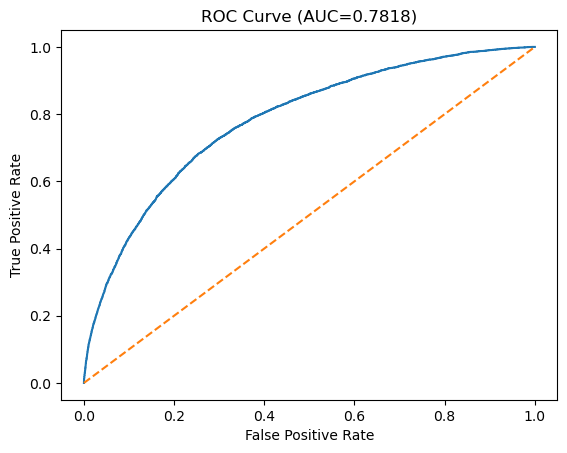

In [6]:
val_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)
val_auc = roc_auc_score(y_val, val_pred_proba)
print("Validation ROC-AUC:", val_auc)

fpr, tpr, _ = roc_curve(y_val, val_pred_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC={val_auc:.4f})")
plt.show()


### ROC Curve

The ROC (Receiver Operating Characteristic) curve above shows the model’s ability to distinguish between defaulters and non-defaulters.

-  The **AUC = 0.7818**, meaning that the model has a **78.2% chance** of ranking a randomly chosen defaulter higher than a non-defaulter.  
- The blue curve represents model performance, while the orange dashed line shows random guessing (AUC = 0.5).  
- The model demonstrates **good discriminative power**, indicating it captures meaningful credit risk signals.  
- However, this can be improved further by hyperparameter tuning or futher feature engineering.

Overall, the ROC curve shows that the current LightGBM model provides a **strong baseline** for Home Credit to use it for risk prediction.

### E. Examine Feature importance

                     feature  importance_gain
31              EXT_SOURCE_3    237352.496437
30              EXT_SOURCE_2    215885.744446
29              EXT_SOURCE_1     97682.940100
109   CREDIT_ANNUITY_PERCENT     46786.141743
130  DEBT_TO_CREDIT_SUM_mean     46428.212221
156      INST_MEAN_LATE_RATE     45537.399414
114        CREDIT_GOODS_DIFF     41735.522446
111              CREDIT_TERM     38587.669077
106   DAYS_EMPLOYED_REPLACED     30409.614883
146        MIN_DAYS_DECISION     30145.838852
8                 DAYS_BIRTH     29595.933098
145     MEAN_PREV_AMT_CREDIT     25581.294682
6            AMT_GOODS_PRICE     25506.079189
157   INST_MEAN_PAYMENT_PERC     23843.607254
108   ANNUITY_INCOME_PERCENT     23672.421988
5                AMT_ANNUITY     23101.706863
164       CC_MAX_UTILIZATION     23085.719629
133          DAYS_CREDIT_max     22456.459806
116              YEARS_BIRTH     21171.179646
149             REFUSAL_RATE     20990.258366


<Figure size 600x800 with 0 Axes>

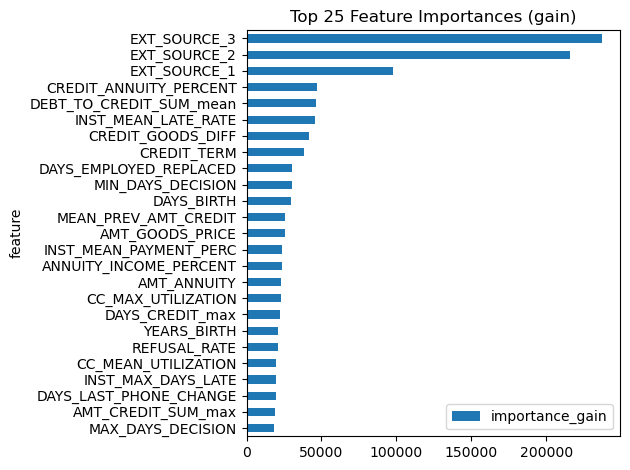

In [7]:
importances = model.feature_importance(importance_type="gain")
feat_imp = (
    pd.DataFrame({
        "feature": X.columns,
        "importance_gain": importances
    })
    .sort_values("importance_gain", ascending=False)
)

print(feat_imp.head(20))

plt.figure(figsize=(6,8))
feat_imp.head(25).sort_values("importance_gain").plot(
    kind="barh",
    x="feature",
    y="importance_gain"
)
plt.title("Top 25 Feature Importances (gain)")
plt.tight_layout()
plt.show()


### Feature Importance 

The chart above displays the **Top 25 most important features** ranked by *gain*. This measues how important each feature is in reducing the prediction error in our model.

- **EXT_SOURCE_3, EXT_SOURCE_2, and EXT_SOURCE_1** (external discrete risk scores obtained by Home Credit from third-party credit scoring providers) are the top predictors
- Influential features also include:
  - **CREDIT_ANNUITY_PERCENT** and **DEBT_TO_CREDIT_SUM_mean** - credit burden and debt structure.
  - **DAYS_BIRTH** and **YEARS_BIRTH** - Age related risk patterns.
  - **DAYS_EMPLOYED_REPLACED** (employment duration) and **MIN_DAYS_DECISION** 
- Monetary ratios (e.g., **AMT_ANNUITY**, **CREDIT_TERM**, **AMT_GOODS_PRICE**) and behavioral metrics from past loans provide additional predictive power.

**Interpretation:**  
The dominance of `EXT_SOURCE` features suggests that **external credit information** heavily influences the default risk prediction. The presence of income, credit, and employment variables also confirm that the model also learns from a balance of  **financial stability** and **demographic** factors.

These top features are well aligned with the financial domain intuition (Experience and Knowledge in assessing an individual's ability to repay the loans) and validate the model’s credibility for credit risk assessment.


### F. Save the validation predictions
These will be used later for tuning

In [8]:
CLEAN_DIR = Path("../data/clean")
OUT_VAL_PATH = CLEAN_DIR / "oof_val_preds.csv"

val_results = pd.DataFrame({
    "SK_ID_CURR": id_val,
    "TARGET": y_val,
    "PRED_PROB": val_pred_proba
})
val_results.to_csv(OUT_VAL_PATH, index=False)
print("Wrote validation preds to:", OUT_VAL_PATH)

val_results.head()


Wrote validation preds to: ../data/clean/oof_val_preds.csv


,SK_ID_CURR,TARGET,PRED_PROB
0,396899,0,0.168384
1,322041,0,0.252755
2,220127,0,0.822849
3,251531,0,0.280272
4,345558,0,0.566044


### G. Train the Final model on the full dataset

In [9]:
# Train final model using all rows
full_lgb_train = lgb.Dataset(X, label=y)

final_model = lgb.train(
    {**params, "verbose": -1},
    full_lgb_train,
    num_boost_round=model.best_iteration  #
)

# predict on test
test_pred_proba = final_model.predict(X_test_final)


In [11]:
# Save model locally
MODEL_DIR = Path("../model")

model_path = MODEL_DIR / "lightgbm_model.txt"
final_model.save_model(str(model_path))